In [1]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from utils.text import *
from sklearn.feature_extraction.text import *
from sklearn.decomposition import NMF
from scipy.sparse import coo_matrix, find

from run_id import run_id
stat = RunStats.objects.get(pk=run_id)
q = stat.query
print(q.title)
print(q.id)

wos_all
365


In [14]:
kws = KW.objects.filter(doc__query=q,kwtype=0,doc__ipccref__isnull=False)
kws.count()

48591

In [15]:
tdf = pd.DataFrame.from_dict(list(kws[:10].values()))
tdf.head()

,id,kwtype,ndocs,text
0,316345,0,0,ph
1,366468,0,0,cumulative effects
2,309827,0,0,climate change
3,402720,0,0,carbonate chemistry
4,321841,0,0,calcification


In [48]:
kw_wg = kws.values('text','doc__ipccref__wg__wg').annotate(
    n = Count('id')
).order_by('-n')

df = pd.DataFrame.from_dict(list(kw_wg)).rename(index=str, columns={"doc__ipccref__wg__wg": "wg"})

df.head()

,wg,n,text
0,2.0,2606,climate change
1,2.0,609,adaptation
2,1.0,540,climate change
3,3.0,501,climate change
4,2.0,297,global warming


In [17]:
pdf = df.pivot('text','wg','n')

pdf.sort_values(1,ascending=False).head()



wg,nan,1.0,2.0,3.0
text,,,,
climate change,NaN,540.0,2606.0,501.0
global warming,NaN,88.0,297.0,85.0
climate,NaN,87.0,166.0,29.0
precipitation,NaN,86.0,79.0,1.0
carbon cycle,NaN,60.0,21.0,14.0


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


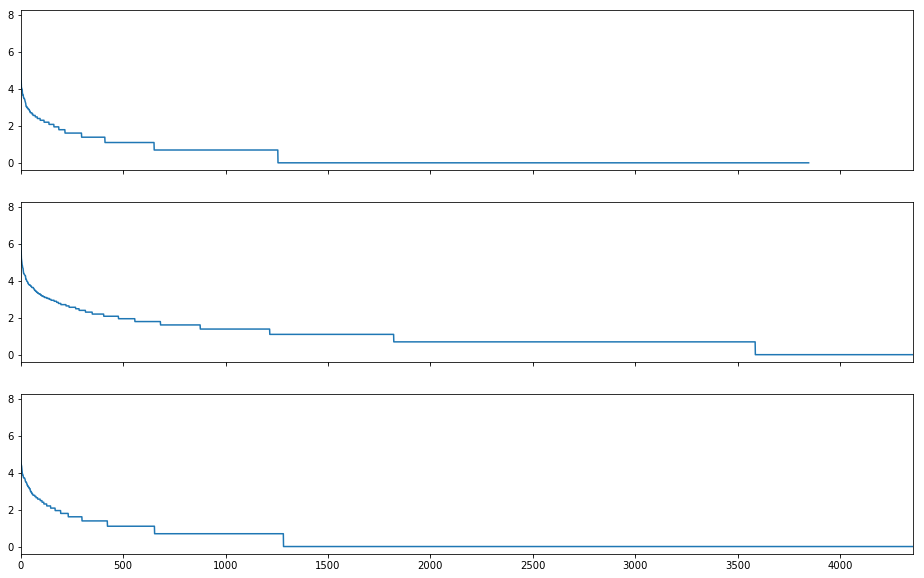

In [51]:
f, axs = plt.subplots(3, sharex=True, sharey=True)
plt.rcParams["figure.figsize"] = [16,10]
for wg in [1,2,3]:
    ax = axs[wg-1]
    wdf = df[(df['wg']==wg)]
    wdf['ln'] = np.log(wdf['n'])
    wdf = wdf.reset_index()
    wdf['ln'].plot.line(ax=ax)
    

plt.show()

In [54]:
kw_tg = kws.values('text','doc__primary_topic__title').annotate(
    n = Count('id')
).order_by('-n')

tdf = pd.DataFrame.from_dict(list(kw_tg)).rename(index=str, columns={"doc__primary_topic__title": "topic"})

tdf.head()

,topic,n,text
0,"{adapt, vulner, strategi}",325,climate change
1,"{adapt, vulner, strategi}",296,adaptation
2,"{adapt, vulner, capac}",296,climate change
3,"{adapt, vulner, capac}",277,adaptation
4,"{crop, yield, wheat}",229,climate change


In [20]:


kwmatrix = kws.filter(kwtype=0,doc__primary_topic__isnull=False).annotate(
    n = Count('id')
).filter(n__gt=1).values('id','doc__id').annotate(
    n = Count('doc__id',distinct=True)
).order_by('-n','-doc__primary_topic__score')

df = pd.DataFrame.from_dict(list(kwmatrix.values('doc__primary_topic__title','doc__id','id','n')))

df.head()


,doc__id,doc__primary_topic__title,id,n
0,282899,None,309827,1
1,260615,None,319857,1
2,367966,None,310650,1
3,260615,None,311304,1
4,40182,None,365542,1


In [58]:


kwmatrix = kws.filter(kwtype=0,doc__primary_topic__isnull=False).annotate(
    n = Count('id')
).filter(n__gt=1).values('id','doc__id').annotate(
    n = Count('doc__id',distinct=True)
).order_by('-n','-doc__primary_topic__score')

df = pd.DataFrame.from_dict(list(kwmatrix.values('doc__primary_topic__title','doc__id','id','n')))

df.head()

<QuerySet [{'doc__id': 442306, 'id': 310261, 'n': 1}, {'doc__id': 78083, 'id': 310651, 'n': 1}, {'doc__id': 62465, 'id': 310117, 'n': 1}, {'doc__id': 529210, 'id': 310217, 'n': 1}, {'doc__id': 260615, 'id': 309827, 'n': 1}, {'doc__id': 367966, 'id': 310650, 'n': 1}, {'doc__id': 442306, 'id': 309827, 'n': 1}, {'doc__id': 367966, 'id': 310055, 'n': 1}, {'doc__id': 268262, 'id': 310157, 'n': 1}, {'doc__id': 14373, 'id': 309827, 'n': 1}, {'doc__id': 40182, 'id': 309827, 'n': 1}, {'doc__id': 34691, 'id': 309827, 'n': 1}, {'doc__id': 517788, 'id': 310482, 'n': 1}, {'doc__id': 3337, 'id': 310650, 'n': 1}, {'doc__id': 265794, 'id': 309827, 'n': 1}, {'doc__id': 282899, 'id': 309827, 'n': 1}, {'doc__id': 529210, 'id': 309827, 'n': 1}, {'doc__id': 34691, 'id': 309859, 'n': 1}, {'doc__id': 3337, 'id': 309827, 'n': 1}, {'doc__id': 517788, 'id': 310770, 'n': 1}, '...(remaining elements truncated)...']>

In [21]:
df['doc'] = pd.Categorical(df['doc__id'],df['doc__id'].unique())

df['topic'] = pd.Categorical(df['doc__primary_topic__title'],df['doc__primary_topic__title'].unique())

print(df.sort_values('doc').head(10))

    doc__id doc__primary_topic__title      id  n     doc topic
0    282899                      None  309827  1  282899  None
49   282899                      None  313598  1  282899  None
72   282899                      None  312145  1  282899  None
73   282899                      None  312751  1  282899  None
54   282899                      None  330012  1  282899  None
45   260615                      None  367941  1  260615  None
80   260615                      None  330404  1  260615  None
76   260615                      None  309827  1  260615  None
3    260615                      None  311304  1  260615  None
1    260615                      None  319857  1  260615  None


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:3: FutureWarning: 
Setting NaNs in `categories` is deprecated and will be removed in a future version of pandas.
  app.launch_new_instance()


In [22]:
pdf = df.pivot('doc','id','topic')

pdf.head()

ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
import seaborn as sns; sns.set()
plt.rcParams["figure.figsize"] = [16,10]
ax = sns.heatmap(pdf,xticklabels=False,yticklabels=False,cmap="Greys",square=True)

s= pdf.shape

ax.text(s[1]/2,s[0]*-0.25,"{} x {}".format(s[0], s[1]),ha="center",va="center")

plt.show()

In [ ]:
from bokeh.io import show
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LinearColorMapper,
    BasicTicker,
    PrintfTickFormatter,
    ColorBar,
)
from bokeh.plotting import figure

docs = pd['doc']


source = ColumnDataSource(pdf)

p = figure()

In [44]:
t = Topic.objects.filter(run_id=run_id).order_by('-score')[5]

print(t.top_words)

tkws = KW.objects.filter(
    doc__doctopic__topic=t,
    doc__doctopic__score__gt=stat.dthreshold,
    kwtype=0
).annotate(
    n = Count('id')
).order_by('-n')

kwdf = pd.DataFrame.from_dict(list(tkws.values('text','n')))

kwdf.head()

['emiss', 'reduct', 'reduc', 'factor', 'total', 'greenhous', 'sector', 'estim', 'inventori', 'industri']


,n,text
0,3866,climate change
1,1756,methane
2,1702,nitrous oxide
3,1270,carbon dioxide
4,1091,greenhouse gas


In [45]:
kwdf.head(15)

,n,text
0,3866,climate change
1,1756,methane
2,1702,nitrous oxide
3,1270,carbon dioxide
4,1091,greenhouse gas
5,1084,co2 emissions
6,1075,greenhouse gases
7,1018,greenhouse gas emissions
8,956,life cycle assessment
9,866,global warming


In [57]:
topwords = TopicTerm.objects.filter(
    topic=t
).order_by('-score').values('term__title','score')

twdf = pd.DataFrame.from_dict(list(topwords))

twdf.head(15)

,score,term__title
0,8.746747,emiss
1,0.810707,reduct
2,0.573662,reduc
3,0.425000,factor
4,0.408051,total
5,0.400393,greenhous
6,0.399722,sector
7,0.399549,estim
8,0.367508,inventori
9,0.364372,industri


In [46]:
docs = set(list(Doc.objects.filter(
    query=q,
    kw__text='water resources'
).values_list('id',flat=True)))

wrs = KW.objects.filter(
    doc__in=docs
).annotate(
    n = Count('doc')
).order_by('-n')

wrdf = pd.DataFrame.from_dict(list(wrs.values('text','n')))

wrdf.head(15)

,n,text
0,532,water resources
1,445,water resources
2,272,climate change
3,259,climate change
4,107,climate-change
5,79,model
6,78,
7,60,precipitation
8,53,management
9,52,variability
